# Profiling main skforecast classes and methods

In [3]:
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path
sys.path.insert(1, str(Path.cwd().parent))
str(Path.cwd().parent)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


'c:\\Users\\jaesc2\\GitHub\\skforecast'

In [4]:
import platform
import psutil
import skforecast
import pandas as pd
import numpy as np
import scipy
import sklearn


import numpy as np
import pandas as pd
import time
import warnings
import logging
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from sklearn.linear_model import Ridge
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMRegressor
from skforecast.model_selection import backtesting_forecaster
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection_multiseries import grid_search_forecaster_multiseries
from skforecast.model_selection_multiseries import backtesting_forecaster_multiseries
from skforecast.model_selection_multiseries import grid_search_forecaster_multivariate
from skforecast.model_selection_multiseries import backtesting_forecaster_multivariate
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregMultiSeries import ForecasterAutoregMultiSeries
from skforecast.ForecasterAutoregMultiVariate import ForecasterAutoregMultiVariate
%load_ext pyinstrument 

The pyinstrument extension is already loaded. To reload it, use:
  %reload_ext pyinstrument


# Information system and libraries

In [5]:
# Versions
# ==============================================================================
print(f"Python version: {platform.python_version()}")
print(f"scikit-learn version: {sklearn.__version__}")
print(f"skforecast version: {skforecast.__version__}")
print(f"pandas version: {pd.__version__}")
print(f"numpy version: {np.__version__}")
print(f"scipy version: {scipy.__version__}")
print(f"psutil version: {psutil.__version__}")
print("")

# Computer information
# ==============================================================================
#Computer network name
print(f"Computer network name: {platform.node()}")
#Machine type
print(f"Machine type: {platform.machine()}")
#Processor type
print(f"Processor type: {platform.processor()}")
#Platform type
print(f"Platform type: {platform.platform()}")
#Operating system
print(f"Operating system: {platform.system()}")
#Operating system release
print(f"Operating system release: {platform.release()}")
#Operating system version
print(f"Operating system version: {platform.version()}")
#Physical cores
print(f"Number of physical cores: {psutil.cpu_count(logical=False)}")
#Logical cores
print(f"Number of logical cores: {psutil.cpu_count(logical=True)}")

Python version: 3.10.11
scikit-learn version: 1.2.2
skforecast version: 0.9.0
pandas version: 2.0.2
numpy version: 1.24.3
scipy version: 1.10.1
psutil version: 5.9.5

Computer network name: ITES015-NB0029
Machine type: AMD64
Processor type: Intel64 Family 6 Model 141 Stepping 1, GenuineIntel
Platform type: Windows-10-10.0.19044-SP0
Operating system: Windows
Operating system release: 10
Operating system version: 10.0.19044
Number of physical cores: 8
Number of logical cores: 16


# Data

In [6]:
# Data
# ==============================================================================
n = 1_000
rgn = np.random.default_rng(seed=123)
y = pd.Series(rgn.random(size=(n)), name="y")
exog = pd.DataFrame(rgn.random(size=(n, 10)))
exog.columns = [f"exog_{i}" for i in range(exog.shape[1])]
multi_series = pd.DataFrame(rgn.random(size=(n, 10)))
multi_series.columns = [f"series_{i+1}" for i in range(multi_series.shape[1])]
y_train = y[:-int(n/2)]
display(y.head())
display(exog.head())   
display(multi_series.head())

0    0.682352
1    0.053821
2    0.220360
3    0.184372
4    0.175906
Name: y, dtype: float64

,exog_0,exog_1,exog_2,exog_3,exog_4,exog_5,exog_6,exog_7,exog_8,exog_9
0,0.461518,0.189507,0.579512,0.939047,0.299072,0.460476,0.057565,0.085302,0.199445,0.630164
1,0.272450,0.949816,0.416202,0.624220,0.565506,0.497016,0.399685,0.446142,0.996017,0.092076
2,0.966146,0.253428,0.798048,0.230935,0.391439,0.712525,0.924496,0.436304,0.609645,0.347455
3,0.209449,0.940346,0.939049,0.976035,0.978222,0.902929,0.560702,0.309192,0.391578,0.292629
4,0.317627,0.766355,0.939779,0.569968,0.713253,0.274080,0.895022,0.530589,0.662251,0.864017


,series_1,series_2,series_3,series_4,series_5,series_6,series_7,series_8,series_9,series_10
0,0.704195,0.267780,0.278684,0.662548,0.550782,0.974412,0.713675,0.222479,0.284444,0.659551
1,0.691730,0.599037,0.114436,0.501143,0.874468,0.918692,0.634778,0.375594,0.672832,0.800555
2,0.861432,0.528304,0.128624,0.868976,0.813967,0.771324,0.823880,0.103483,0.964655,0.618299
3,0.942510,0.862702,0.222000,0.206061,0.118639,0.824293,0.111561,0.923191,0.381270,0.197078
4,0.928211,0.664412,0.644306,0.721082,0.468421,0.397217,0.424951,0.510830,0.620913,0.401468


# Profiling ForecasterAutoreg

In [7]:
warnings.filterwarnings("ignore")

In [8]:
# Forecaster
# ==============================================================================
print("-----------------")
print("ForecasterAutoreg")
print("-----------------")

steps = 100
lags = 50

regressors = [
    Ridge(random_state=77, alpha=0.1),
    LGBMRegressor(random_state=77, n_jobs=1, n_estimators=50, max_depth=5),
    LGBMRegressor(random_state=77, n_jobs=-1, n_estimators=50, max_depth=5),
    HistGradientBoostingRegressor(random_state=77, max_iter=50, max_depth=5),
    RandomForestRegressor(random_state=77, n_jobs=1, n_estimators=25, max_depth=5),
    RandomForestRegressor(random_state=77, n_jobs=-1, n_estimators=25, max_depth=5),
]
param_grids = [
    {'alpha': [0.1, 0.1, 0.1]},
    {'n_estimators': [50, 50], 'max_depth': [5, 5]},
    {'n_estimators': [50, 50], 'max_depth': [5, 5]},
    {'max_iter': [50, 50], 'max_depth': [5, 5]},
    {'n_estimators': [25, 25], 'max_depth': [5, 5]},
    {'n_estimators': [25, 25], 'max_depth': [5, 5]}
]
lags_grid = [50, 50, 50]

elapsed_times = []

for regressor, param_grid in zip(regressors, param_grids):
    print("")
    print(regressor, param_grid)
    print("")
    forecaster = ForecasterAutoreg(
                        regressor=regressor,
                        lags=lags,
                        transformer_exog=StandardScaler()
                )
    
    # Profiling fit
    # ==============================================================================
    print("Profiling fit")
    start = time.time()
    forecaster.fit(y=y, exog=exog)
    end = time.time()
    elapsed_times.append(end - start)
    
    # Profiling create_train_X_y
    # ==============================================================================
    print("Profiling create_train_X_y")
    start = time.time()
    _ = forecaster.create_train_X_y(y=y, exog=exog)
    end = time.time()
    elapsed_times.append(end - start)

    # Profiling backtesting refit and parallel
    # ==============================================================================
    print("Profiling backtesting refit and parallel")
    start = time.time()
    metric, backtest_predictions = backtesting_forecaster(
                                forecaster          = forecaster,
                                    y                   = y,
                                    exog                = exog,
                                    initial_train_size  = len(y_train),
                                    fixed_train_size    = False,
                                    steps               = steps,
                                    metric              = 'mean_squared_error',
                                    refit               = True,
                                    interval            = None,
                                    n_boot              = 500,
                                    random_state        = 123,
                                    in_sample_residuals = True,
                                    verbose             = False,
                                    show_progress       = False,
                                    n_jobs              = -1
                            )
    end = time.time()
    elapsed_times.append(end - start)
    
    # Profiling backtesting refit and no parallel
    # ==============================================================================
    print("Profiling backtesting refit and no parallel")
    start = time.time()
    metric, backtest_predictions = backtesting_forecaster(
                                    forecaster          = forecaster,
                                    y                   = y,
                                    exog                = exog,
                                    initial_train_size  = len(y_train),
                                    fixed_train_size    = False,
                                    steps               = steps,
                                    metric              = 'mean_squared_error',
                                    refit               = True,
                                    interval            = None,
                                    n_boot              = 500,
                                    random_state        = 123,
                                    in_sample_residuals = True,
                                    verbose             = False,
                                    show_progress       = False,
                                    n_jobs              = 1
                            )
    end = time.time()
    elapsed_times.append(end - start)
    
    # Profiling backtesting no refit and parallel
    # ==============================================================================
    print("Profiling backtesting no refit and parallel")
    start = time.time()
    metric, backtest_predictions = backtesting_forecaster(
                                    forecaster          = forecaster,
                                    y                   = y,
                                    exog                = exog,
                                    initial_train_size  = len(y_train),
                                    fixed_train_size    = False,
                                    steps               = steps,
                                    metric              = 'mean_squared_error',
                                    refit               = False,
                                    interval            = None,
                                    n_boot              = 500,
                                    random_state        = 123,
                                    in_sample_residuals = True,
                                    verbose             = False,
                                    show_progress       = False,
                                    n_jobs              = -1
                            )
    end = time.time()
    elapsed_times.append(end - start)
    
    # Profiling backtesting no refit and no parallel
    # ==============================================================================
    print("Profiling backtesting no refit and no parallel")
    start = time.time()
    metric, backtest_predictions = backtesting_forecaster(
                                    forecaster          = forecaster,
                                    y                   = y,
                                    exog                = exog,
                                    initial_train_size  = len(y_train),
                                    fixed_train_size    = False,
                                    steps               = steps,
                                    metric              = 'mean_squared_error',
                                    refit               = False,
                                    interval            = None,
                                    n_boot              = 500,
                                    random_state        = 123,
                                    in_sample_residuals = True,
                                    verbose             = False,
                                    show_progress       = False,
                                    n_jobs              = 1
                            )
    end = time.time()
    elapsed_times.append(end - start)    
    
    # gridSearch no refit parallel
    # ==============================================================================
    print("Profiling gridSearch no refit parallel")
    start = time.time()
    results_grid = grid_search_forecaster(
                    forecaster          = forecaster,
                    y                   = y,
                    exog                = exog,
                    initial_train_size  = len(y_train),
                    steps               = steps,
                    param_grid         = param_grid,
                    lags_grid          = lags_grid,
                    refit              = False,
                    metric             = 'mean_squared_error',
                    fixed_train_size   = False,
                    return_best        = False,
                    verbose            = False,
                    show_progress      = False,
                    n_jobs             = -1
            )
    end = time.time()
    elapsed_times.append(end - start)
    
    # GridSearch no refit no parallel
    # ==============================================================================
    print("Profiling gridSearch no refit no parallel")
    start = time.time()
    results_grid = grid_search_forecaster(
                    forecaster          = forecaster,
                    y                   = y,
                    exog                = exog,
                    initial_train_size  = len(y_train),
                    steps               = steps,
                    param_grid         = param_grid,
                    lags_grid          = lags_grid,
                    refit              = False,
                    metric             = 'mean_squared_error',
                    fixed_train_size   = False,
                    return_best        = False,
                    verbose            = False,
                    show_progress      = False,
                    n_jobs             = 1
            )
    end = time.time()
    elapsed_times.append(end - start)


methods = [
    "fit",
    "create_train_X_y",
    "backtest_refit_parallel",
    "backtest_refit_noparallel",
    "backtest_no_refit_parallel",
    "backtest_no_refit_noparallel",
    "gridSearch_no_refit_parallel",
    "gridSearch_no_refit_noparallel"
]

results = pd.DataFrame({
     "regressor": np.repeat(np.array([str(regressor) for regressor in regressors]), len(methods)),
     "method": np.tile(methods, len(regressors)),
     "elapsed_time": elapsed_times
})

results['parallel'] = results.method.str.contains("_parallel")
results['method'] = results.method.str.replace("_parallel", "")
results['method'] = results.method.str.replace("_noparallel", "")
results = results.sort_values(by=["regressor", "method", "parallel"])
results.to_csv(f"javi_profiling_results_ForecasterAutoreg_{n}.csv", index=False)
results

-----------------
ForecasterAutoreg
-----------------

Ridge(alpha=0.1, random_state=77) {'alpha': [0.1, 0.1, 0.1]}

Profiling fit
Profiling create_train_X_y
Profiling backtesting refit and parallel
Profiling backtesting refit and no parallel
Profiling backtesting no refit and parallel
Profiling backtesting no refit and no parallel
Profiling gridSearch no refit parallel
Number of models compared: 9.
Profiling gridSearch no refit no parallel
Number of models compared: 9.

LGBMRegressor(max_depth=5, n_estimators=50, n_jobs=1, random_state=77) {'n_estimators': [50, 50], 'max_depth': [5, 5]}

Profiling fit
Profiling create_train_X_y
Profiling backtesting refit and parallel
Profiling backtesting refit and no parallel
Profiling backtesting no refit and parallel
Profiling backtesting no refit and no parallel
Profiling gridSearch no refit parallel
Number of models compared: 12.
Profiling gridSearch no refit no parallel
Number of models compared: 12.

LGBMRegressor(max_depth=5, n_estimators=50,

,regressor,method,elapsed_time,parallel
29,"HistGradientBoostingRegressor(max_depth=5, max...",backtest_no_refit,0.314404,False
28,"HistGradientBoostingRegressor(max_depth=5, max...",backtest_no_refit,0.229162,True
27,"HistGradientBoostingRegressor(max_depth=5, max...",backtest_refit,0.834796,False
26,"HistGradientBoostingRegressor(max_depth=5, max...",backtest_refit,0.272712,True
25,"HistGradientBoostingRegressor(max_depth=5, max...",create_train_X_y,0.002999,False
24,"HistGradientBoostingRegressor(max_depth=5, max...",fit,0.145039,False
31,"HistGradientBoostingRegressor(max_depth=5, max...",gridSearch_no_refit,4.026723,False
30,"HistGradientBoostingRegressor(max_depth=5, max...",gridSearch_no_refit,2.140218,True
13,"LGBMRegressor(max_depth=5, n_estimators=50, n_...",backtest_no_refit,0.084234,False
12,"LGBMRegressor(max_depth=5, n_estimators=50, n_...",backtest_no_refit,0.173496,True


,regressor,method,False,True,pct_diff
0,"HistGradientBoostingRegressor(max_depth=5, max...",backtest_no_refit,0.314404,0.229162,27.112164
1,"HistGradientBoostingRegressor(max_depth=5, max...",backtest_refit,0.834796,0.272712,67.331889
2,"HistGradientBoostingRegressor(max_depth=5, max...",create_train_X_y,0.002999,NaN,NaN
3,"HistGradientBoostingRegressor(max_depth=5, max...",fit,0.145039,NaN,NaN
4,"HistGradientBoostingRegressor(max_depth=5, max...",gridSearch_no_refit,4.026723,2.140218,46.849627
5,"LGBMRegressor(max_depth=5, n_estimators=50, n_...",backtest_no_refit,0.084234,0.173496,-105.970263
6,"LGBMRegressor(max_depth=5, n_estimators=50, n_...",backtest_refit,0.303181,0.206774,31.798586
7,"LGBMRegressor(max_depth=5, n_estimators=50, n_...",create_train_X_y,0.003520,NaN,NaN
8,"LGBMRegressor(max_depth=5, n_estimators=50, n_...",fit,0.071869,NaN,NaN
9,"LGBMRegressor(max_depth=5, n_estimators=50, n_...",gridSearch_no_refit,1.000118,0.956635,4.347787


Text(0.5, 0, 'Method')

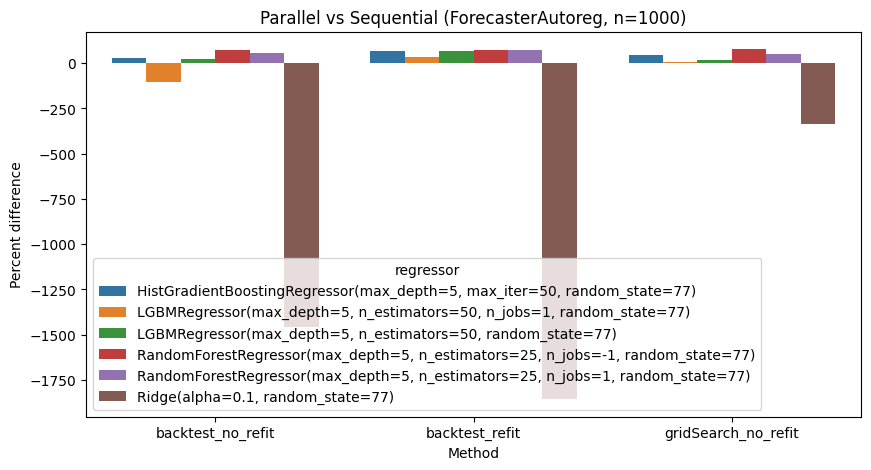

In [9]:
results_pivot = results.pivot_table(index=["regressor", "method"], columns="parallel", values="elapsed_time").reset_index()
results_pivot.columns.name = None
results_pivot["pct_diff"] = (results_pivot[False] - results_pivot[True]) / results_pivot[False] * 100
display(results_pivot)
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(data=results_pivot.dropna(), x="method", y="pct_diff", hue="regressor", ax=ax)
ax.set_title(f"Parallel vs Sequential (ForecasterAutoreg, n={n})")
ax.set_ylabel("Percent difference")
ax.set_xlabel("Method")
#ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right");

In [10]:
# results = pd.read_csv("profiling_results_forecasterautoreg.csv")
# for regressor in results.regressor.unique():
#     df = results[results.regressor == regressor].copy()
#     #Plot results in a bar plot with a diferent color por parallel and no parallel
#     # ==============================================================================
#     fig, ax = plt.subplots(figsize=(10, 5))
#     sns.barplot(data=df, x="method", y="elapsed_time", hue="parallel", ax=ax)
#     ax.set_title(regressor)
#     ax.set_ylabel("Elapsed time (seconds)")
#     ax.set_xlabel("Method")
#     ax.set_yscale('log')
#     plt.show()
    

In [11]:
regressor =LGBMRegressor(random_state=77, n_jobs=-1)
forecaster = ForecasterAutoreg(regressor=regressor, lags=lags, transformer_exog=StandardScaler())
print("Profiling gridSearch refit parallel")
print(regressor)
param_grid = [
    {'n_estimators': [100, 100], 'max_depth': [5, 5]}
]
lags_grid = [50, 50, 50]
start = time.time()
results_grid = grid_search_forecaster(
                forecaster          = forecaster,
                y                   = y,
                exog                = exog,
                initial_train_size  = len(y_train),
                steps               = steps,
                param_grid         = param_grid,
                lags_grid          = lags_grid,
                refit              = False,
                metric             = 'mean_squared_error',
                fixed_train_size   = False,
                return_best        = False,
                verbose            = False,
                show_progress      = False,
                n_jobs             = -1
        )
end = time.time()
print(end - start)

Profiling gridSearch refit parallel
LGBMRegressor(random_state=77)
Number of models compared: 12.
1.512913465499878


# Profiling ForecasterAutoregDirect

In [12]:
# Forecaster
# ==============================================================================
print("-----------------------")
print("ForecasterAutoregDirect")
print("-----------------------")

steps = 25
lags = 50

regressors = [
    Ridge(random_state=77, alpha=0.1),
    LGBMRegressor(random_state=77, n_jobs=1, n_estimators=50, max_depth=5),
    LGBMRegressor(random_state=77, n_jobs=-1, n_estimators=50, max_depth=5),
    HistGradientBoostingRegressor(random_state=77, max_iter=50, max_depth=5),
    RandomForestRegressor(random_state=77, n_jobs=1, n_estimators=25, max_depth=5),
    RandomForestRegressor(random_state=77, n_jobs=-1, n_estimators=25, max_depth=5),
]
param_grids = [
    {'alpha': [0.1, 0.1, 0.1]},
    {'n_estimators': [50, 50], 'max_depth': [5, 5]},
    {'n_estimators': [50, 50], 'max_depth': [5, 5]},
    {'max_iter': [50, 50], 'max_depth': [5, 5]},
    {'n_estimators': [25, 25], 'max_depth': [5, 5]},
    {'n_estimators': [25, 25], 'max_depth': [5, 5]}
]
lags_grid = [50, 50, 50]

elapsed_times = []

for regressor, param_grid in zip(regressors, param_grids):
    print("")
    print(regressor, param_grid)
    print("")
    forecaster = ForecasterAutoregDirect(
                    regressor=regressor,
                    lags=lags,
                    steps=steps,
                    transformer_exog=StandardScaler()
                )
    
    # Profiling fit
    # ==============================================================================
    print("Profiling fit")
    start = time.time()
    forecaster.fit(y=y, exog=exog)
    end = time.time()
    elapsed_times.append(end - start)
    
    # Profiling create_train_X_y
    # ==============================================================================
    print("Profiling create_train_X_y")
    start = time.time()
    _ = forecaster.create_train_X_y(y=y, exog=exog)
    end = time.time()
    elapsed_times.append(end - start)

    # Profiling backtesting refit and parallel
    # ==============================================================================
    print("Profiling backtesting refit and parallel")
    start = time.time()
    metric, backtest_predictions = backtesting_forecaster(
                                forecaster          = forecaster,
                                    y                   = y,
                                    exog                = exog,
                                    initial_train_size  = int(len(y)*0.9),
                                    fixed_train_size    = False,
                                    steps               = steps,
                                    metric              = 'mean_squared_error',
                                    refit               = True,
                                    interval            = None,
                                    n_boot              = 500,
                                    random_state        = 123,
                                    in_sample_residuals = True,
                                    verbose             = False,
                                    show_progress       = False,
                                    n_jobs              = -1
                            )
    end = time.time()
    elapsed_times.append(end - start)
    
    # Profiling backtesting refit and no parallel
    # ==============================================================================
    print("Profiling backtesting refit and no parallel")
    start = time.time()
    metric, backtest_predictions = backtesting_forecaster(
                                    forecaster          = forecaster,
                                    y                   = y,
                                    exog                = exog,
                                    initial_train_size  = int(len(y)*0.9),
                                    fixed_train_size    = False,
                                    steps               = steps,
                                    metric              = 'mean_squared_error',
                                    refit               = True,
                                    interval            = None,
                                    n_boot              = 500,
                                    random_state        = 123,
                                    in_sample_residuals = True,
                                    verbose             = False,
                                    show_progress       = False,
                                    n_jobs              = 1
                            )
    end = time.time()
    elapsed_times.append(end - start)
    
    # Profiling backtesting no refit and parallel
    # ==============================================================================
    print("Profiling backtesting no refit and parallel")
    start = time.time()
    metric, backtest_predictions = backtesting_forecaster(
                                    forecaster          = forecaster,
                                    y                   = y,
                                    exog                = exog,
                                    initial_train_size  = int(len(y)*0.9),
                                    fixed_train_size    = False,
                                    steps               = steps,
                                    metric              = 'mean_squared_error',
                                    refit               = False,
                                    interval            = None,
                                    n_boot              = 500,
                                    random_state        = 123,
                                    in_sample_residuals = True,
                                    verbose             = False,
                                    show_progress       = False,
                                    n_jobs              = -1
                            )
    end = time.time()
    elapsed_times.append(end - start)
    
    # Profiling backtesting no refit and no parallel
    # ==============================================================================
    print("Profiling backtesting no refit and no parallel")
    start = time.time()
    metric, backtest_predictions = backtesting_forecaster(
                                    forecaster          = forecaster,
                                    y                   = y,
                                    exog                = exog,
                                    initial_train_size  = int(len(y)*0.9),
                                    fixed_train_size    = False,
                                    steps               = steps,
                                    metric              = 'mean_squared_error',
                                    refit               = False,
                                    interval            = None,
                                    n_boot              = 500,
                                    random_state        = 123,
                                    in_sample_residuals = True,
                                    verbose             = False,
                                    show_progress       = False,
                                    n_jobs              = 1
                            )
    end = time.time()
    elapsed_times.append(end - start)    
    
    # gridSearch no refit parallel
    # ==============================================================================
    print("Profiling gridSearch no refit parallel")
    start = time.time()
    results_grid = grid_search_forecaster(
                    forecaster          = forecaster,
                    y                   = y,
                    exog                = exog,
                    initial_train_size  = int(len(y)*0.9),
                    steps               = steps,
                    param_grid         = param_grid,
                    lags_grid          = lags_grid,
                    refit              = False,
                    metric             = 'mean_squared_error',
                    fixed_train_size   = False,
                    return_best        = False,
                    verbose            = False,
                    show_progress      = False,
                    n_jobs             = -1
            )
    end = time.time()
    elapsed_times.append(end - start)
    
    # GridSearch no refit no parallel
    # ==============================================================================
    print("Profiling gridSearch no refit no parallel")
    start = time.time()
    results_grid = grid_search_forecaster(
                    forecaster          = forecaster,
                    y                   = y,
                    exog                = exog,
                    initial_train_size  = int(len(y)*0.9),
                    steps               = steps,
                    param_grid         = param_grid,
                    lags_grid          = lags_grid,
                    refit              = False,
                    metric             = 'mean_squared_error',
                    fixed_train_size   = False,
                    return_best        = False,
                    verbose            = False,
                    show_progress      = False,
                    n_jobs             = 1
            )
    end = time.time()
    elapsed_times.append(end - start)


methods = [
    "fit",
    "create_train_X_y",
    "backtest_refit_parallel",
    "backtest_refit_noparallel",
    "backtest_no_refit_parallel",
    "backtest_no_refit_noparallel",
    "gridSearch_no_refit_parallel",
    "gridSearch_no_refit_noparallel"
]

results = pd.DataFrame({
     "regressor": np.repeat(np.array([str(regressor) for regressor in regressors]), len(methods)),
     "method": np.tile(methods, len(regressors)),
     "elapsed_time": elapsed_times
})

results['parallel'] = results.method.str.contains("_parallel")
results['method'] = results.method.str.replace("_parallel", "")
results['method'] = results.method.str.replace("_noparallel", "")
results = results.sort_values(by=["regressor", "method", "parallel"])
results.to_csv(f"javi_profiling_results_ForecasterAutoregDirect_{n}.csv", index=False)
results

-----------------------
ForecasterAutoregDirect
-----------------------

Ridge(alpha=0.1, random_state=77) {'alpha': [0.1, 0.1, 0.1]}

Profiling fit
Profiling create_train_X_y
Profiling backtesting refit and parallel
Profiling backtesting refit and no parallel
Profiling backtesting no refit and parallel
Profiling backtesting no refit and no parallel
Profiling gridSearch no refit parallel
Number of models compared: 9.
Profiling gridSearch no refit no parallel
Number of models compared: 9.

LGBMRegressor(max_depth=5, n_estimators=50, n_jobs=1, random_state=77) {'n_estimators': [50, 50], 'max_depth': [5, 5]}

Profiling fit
Profiling create_train_X_y
Profiling backtesting refit and parallel
Profiling backtesting refit and no parallel
Profiling backtesting no refit and parallel
Profiling backtesting no refit and no parallel
Profiling gridSearch no refit parallel
Number of models compared: 12.
Profiling gridSearch no refit no parallel
Number of models compared: 12.

LGBMRegressor(max_depth=5

,regressor,method,elapsed_time,parallel
29,"HistGradientBoostingRegressor(max_depth=5, max...",backtest_no_refit,3.009290,False
28,"HistGradientBoostingRegressor(max_depth=5, max...",backtest_no_refit,3.541631,True
27,"HistGradientBoostingRegressor(max_depth=5, max...",backtest_refit,11.777533,False
26,"HistGradientBoostingRegressor(max_depth=5, max...",backtest_refit,4.149778,True
25,"HistGradientBoostingRegressor(max_depth=5, max...",create_train_X_y,0.008000,False
24,"HistGradientBoostingRegressor(max_depth=5, max...",fit,3.373242,False
31,"HistGradientBoostingRegressor(max_depth=5, max...",gridSearch_no_refit,35.083740,False
30,"HistGradientBoostingRegressor(max_depth=5, max...",gridSearch_no_refit,42.480280,True
13,"LGBMRegressor(max_depth=5, n_estimators=50, n_...",backtest_no_refit,1.490654,False
12,"LGBMRegressor(max_depth=5, n_estimators=50, n_...",backtest_no_refit,1.795450,True


,regressor,method,False,True,pct_diff
0,"HistGradientBoostingRegressor(max_depth=5, max...",backtest_no_refit,3.009290,3.541631,-17.689936
1,"HistGradientBoostingRegressor(max_depth=5, max...",backtest_refit,11.777533,4.149778,64.765299
2,"HistGradientBoostingRegressor(max_depth=5, max...",create_train_X_y,0.008000,NaN,NaN
3,"HistGradientBoostingRegressor(max_depth=5, max...",fit,3.373242,NaN,NaN
4,"HistGradientBoostingRegressor(max_depth=5, max...",gridSearch_no_refit,35.083740,42.480280,-21.082528
5,"LGBMRegressor(max_depth=5, n_estimators=50, n_...",backtest_no_refit,1.490654,1.795450,-20.447147
6,"LGBMRegressor(max_depth=5, n_estimators=50, n_...",backtest_refit,5.871698,2.054783,65.005310
7,"LGBMRegressor(max_depth=5, n_estimators=50, n_...",create_train_X_y,0.006993,NaN,NaN
8,"LGBMRegressor(max_depth=5, n_estimators=50, n_...",fit,1.551049,NaN,NaN
9,"LGBMRegressor(max_depth=5, n_estimators=50, n_...",gridSearch_no_refit,16.398763,20.203983,-23.204310


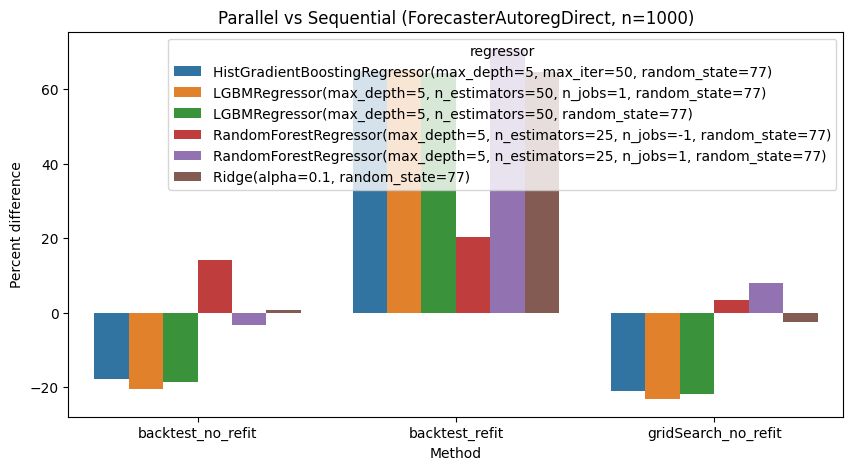

In [13]:
results_pivot = results.pivot_table(index=["regressor", "method"], columns="parallel", values="elapsed_time").reset_index()
results_pivot.columns.name = None
results_pivot["pct_diff"] = (results_pivot[False] - results_pivot[True]) / results_pivot[False] * 100
display(results_pivot)
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(data=results_pivot.dropna(), x="method", y="pct_diff", hue="regressor", ax=ax)
ax.set_title(f"Parallel vs Sequential (ForecasterAutoregDirect, n={n})")
ax.set_ylabel("Percent difference")
ax.set_xlabel("Method");
#ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right");

Paralelizar el método fit del direct para que los modelos se entrenen en paralelo.

# ForecasterAutoregMultiSeries

In [14]:
# Forecaster
# ==============================================================================
print("----------------------------")
print("ForecasterAutoregMultiseries")
print("----------------------------")

steps = 100
lags = 50

regressors = [
    Ridge(random_state=77, alpha=0.1),
    LGBMRegressor(random_state=77, n_jobs=1, n_estimators=50, max_depth=5),
    LGBMRegressor(random_state=77, n_jobs=-1, n_estimators=50, max_depth=5),
    HistGradientBoostingRegressor(random_state=77, max_iter=50, max_depth=5),
    RandomForestRegressor(random_state=77, n_jobs=1, n_estimators=25, max_depth=5),
    RandomForestRegressor(random_state=77, n_jobs=-1, n_estimators=25, max_depth=5),
]
param_grids = [
    {'alpha': [0.1, 0.1, 0.1]},
    {'n_estimators': [50, 50], 'max_depth': [5, 5]},
    {'n_estimators': [50, 50], 'max_depth': [5, 5]},
    {'max_iter': [50, 50], 'max_depth': [5, 5]},
    {'n_estimators': [25, 25], 'max_depth': [5, 5]},
    {'n_estimators': [25, 25], 'max_depth': [5, 5]}
]
lags_grid = [50, 50, 50]

elapsed_times = []

for regressor, param_grid in zip(regressors, param_grids):
    print("")
    print(regressor, param_grid)
    print("")
    forecaster = ForecasterAutoregMultiSeries(
        regressor=regressor,
        lags=lags,
        transformer_exog=StandardScaler()
    )
    
    # Profiling fit
    # ==============================================================================
    print("Profiling fit")
    start = time.time()
    forecaster.fit(series=multi_series, exog=exog)
    end = time.time()
    elapsed_times.append(end - start)
    
    # Profiling create_train_X_y
    # ==============================================================================
    print("Profiling create_train_X_y")
    start = time.time()
    _ = forecaster.create_train_X_y(series=multi_series, exog=exog)
    end = time.time()
    elapsed_times.append(end - start)

    # Profiling backtesting refit and parallel
    # ==============================================================================
    print("Profiling backtesting refit and parallel")
    start = time.time()
    metric, backtest_predictions = backtesting_forecaster_multiseries(
                                    forecaster          = forecaster,
                                    series              = multi_series,
                                    exog                = exog,
                                    initial_train_size  = len(y_train),
                                    fixed_train_size    = False,
                                    steps               = steps,
                                    metric              = 'mean_squared_error',
                                    refit               = True,
                                    interval            = None,
                                    n_boot              = 500,
                                    random_state        = 123,
                                    in_sample_residuals = True,
                                    verbose             = False,
                                    show_progress       = False,
                                    n_jobs              = -1
                            )
    end = time.time()
    elapsed_times.append(end - start)
    
    # Profiling backtesting refit and no parallel
    # ==============================================================================
    print("Profiling backtesting refit and no parallel")
    start = time.time()
    metric, backtest_predictions = backtesting_forecaster_multiseries(
                                    forecaster          = forecaster,
                                    series              = multi_series,
                                    exog                = exog,
                                    initial_train_size  = len(y_train),
                                    fixed_train_size    = False,
                                    steps               = steps,
                                    metric              = 'mean_squared_error',
                                    refit               = True,
                                    interval            = None,
                                    n_boot              = 500,
                                    random_state        = 123,
                                    in_sample_residuals = True,
                                    verbose             = False,
                                    show_progress       = False,
                                    n_jobs              = 1
                            )
    end = time.time()
    elapsed_times.append(end - start)
    
    # Profiling backtesting no refit and parallel
    # ==============================================================================
    print("Profiling backtesting no refit and parallel")
    start = time.time()
    metric, backtest_predictions = backtesting_forecaster_multiseries(
                                    forecaster          = forecaster,
                                    series              = multi_series,
                                    exog                = exog,
                                    initial_train_size  = len(y_train),
                                    fixed_train_size    = False,
                                    steps               = steps,
                                    metric              = 'mean_squared_error',
                                    refit               = False,
                                    interval            = None,
                                    n_boot              = 500,
                                    random_state        = 123,
                                    in_sample_residuals = True,
                                    verbose             = False,
                                    show_progress       = False,
                                    n_jobs              = -1
                            )
    end = time.time()
    elapsed_times.append(end - start)
    
    # Profiling backtesting no refit and no parallel
    # ==============================================================================
    print("Profiling backtesting no refit and no parallel")
    start = time.time()
    metric, backtest_predictions = backtesting_forecaster_multiseries(
                                    forecaster          = forecaster,
                                    series              = multi_series,
                                    exog                = exog,
                                    initial_train_size  = len(y_train),
                                    fixed_train_size    = False,
                                    steps               = steps,
                                    metric              = 'mean_squared_error',
                                    refit               = False,
                                    interval            = None,
                                    n_boot              = 500,
                                    random_state        = 123,
                                    in_sample_residuals = True,
                                    verbose             = False,
                                    show_progress       = False,
                                    n_jobs              = 1
                            )
    end = time.time()
    elapsed_times.append(end - start)    
    
    # gridSearch no refit parallel
    # ==============================================================================
    print("Profiling gridSearch no refit parallel")
    start = time.time()
    results_grid = grid_search_forecaster_multiseries(
                    forecaster          = forecaster,
                    series              = multi_series,
                    exog                = exog,
                    initial_train_size  = len(y_train),
                    steps               = steps,
                    param_grid         = param_grid,
                    lags_grid          = lags_grid,
                    refit              = False,
                    metric             = 'mean_squared_error',
                    fixed_train_size   = False,
                    return_best        = False,
                    verbose            = False,
                    show_progress      = False,
                    n_jobs             = -1
            )
    end = time.time()
    elapsed_times.append(end - start)
    
    # GridSearch no refit no parallel
    # ==============================================================================
    print("Profiling gridSearch no refit no parallel")
    start = time.time()
    results_grid = grid_search_forecaster_multiseries(
                    forecaster          = forecaster,
                    series              = multi_series,
                    exog                = exog,
                    initial_train_size  = len(y_train),
                    steps               = steps,
                    param_grid         = param_grid,
                    lags_grid          = lags_grid,
                    refit              = False,
                    metric             = 'mean_squared_error',
                    fixed_train_size   = False,
                    return_best        = False,
                    verbose            = False,
                    show_progress      = False,
                    n_jobs             = 1
            )
    end = time.time()
    elapsed_times.append(end - start)


methods = [
    "fit",
    "create_train_X_y",
    "backtest_refit_parallel",
    "backtest_refit_noparallel",
    "backtest_no_refit_parallel",
    "backtest_no_refit_noparallel",
    "gridSearch_no_refit_parallel",
    "gridSearch_no_refit_noparallel"
]

results = pd.DataFrame({
     "regressor": np.repeat(np.array([str(regressor) for regressor in regressors]), len(methods)),
     "method": np.tile(methods, len(regressors)),
     "elapsed_time": elapsed_times
})

results['parallel'] = results.method.str.contains("_parallel")
results['method'] = results.method.str.replace("_parallel", "")
results['method'] = results.method.str.replace("_noparallel", "")
results = results.sort_values(by=["regressor", "method", "parallel"])
results.to_csv(f"javi_profiling_results_ForecasterAutoregMultiSeries_{n}.csv", index=False)
results

----------------------------
ForecasterAutoregMultiseries
----------------------------

Ridge(alpha=0.1, random_state=77) {'alpha': [0.1, 0.1, 0.1]}

Profiling fit
Profiling create_train_X_y
Profiling backtesting refit and parallel
Profiling backtesting refit and no parallel
Profiling backtesting no refit and parallel
Profiling backtesting no refit and no parallel
Profiling gridSearch no refit parallel
9 models compared for 10 level(s). Number of iterations: 9.
Profiling gridSearch no refit no parallel
9 models compared for 10 level(s). Number of iterations: 9.

LGBMRegressor(max_depth=5, n_estimators=50, n_jobs=1, random_state=77) {'n_estimators': [50, 50], 'max_depth': [5, 5]}

Profiling fit
Profiling create_train_X_y
Profiling backtesting refit and parallel
Profiling backtesting refit and no parallel
Profiling backtesting no refit and parallel
Profiling backtesting no refit and no parallel
Profiling gridSearch no refit parallel
12 models compared for 10 level(s). Number of iteration

,regressor,method,elapsed_time,parallel
29,"HistGradientBoostingRegressor(max_depth=5, max...",backtest_no_refit,2.292744,False
28,"HistGradientBoostingRegressor(max_depth=5, max...",backtest_no_refit,0.635429,True
27,"HistGradientBoostingRegressor(max_depth=5, max...",backtest_refit,3.094681,False
26,"HistGradientBoostingRegressor(max_depth=5, max...",backtest_refit,0.759841,True
25,"HistGradientBoostingRegressor(max_depth=5, max...",create_train_X_y,0.012171,False
24,"HistGradientBoostingRegressor(max_depth=5, max...",fit,0.316956,False
31,"HistGradientBoostingRegressor(max_depth=5, max...",gridSearch_no_refit,27.121400,False
30,"HistGradientBoostingRegressor(max_depth=5, max...",gridSearch_no_refit,8.344388,True
13,"LGBMRegressor(max_depth=5, n_estimators=50, n_...",backtest_no_refit,0.506694,False
12,"LGBMRegressor(max_depth=5, n_estimators=50, n_...",backtest_no_refit,0.243156,True


,regressor,method,False,True,pct_diff
0,"HistGradientBoostingRegressor(max_depth=5, max...",backtest_no_refit,2.292744,0.635429,72.285203
1,"HistGradientBoostingRegressor(max_depth=5, max...",backtest_refit,3.094681,0.759841,75.446865
2,"HistGradientBoostingRegressor(max_depth=5, max...",create_train_X_y,0.012171,NaN,NaN
3,"HistGradientBoostingRegressor(max_depth=5, max...",fit,0.316956,NaN,NaN
4,"HistGradientBoostingRegressor(max_depth=5, max...",gridSearch_no_refit,27.121400,8.344388,69.233194
5,"LGBMRegressor(max_depth=5, n_estimators=50, n_...",backtest_no_refit,0.506694,0.243156,52.011289
6,"LGBMRegressor(max_depth=5, n_estimators=50, n_...",backtest_refit,1.135870,0.313575,72.393405
7,"LGBMRegressor(max_depth=5, n_estimators=50, n_...",create_train_X_y,0.012136,NaN,NaN
8,"LGBMRegressor(max_depth=5, n_estimators=50, n_...",fit,0.223745,NaN,NaN
9,"LGBMRegressor(max_depth=5, n_estimators=50, n_...",gridSearch_no_refit,5.941209,2.820077,52.533613


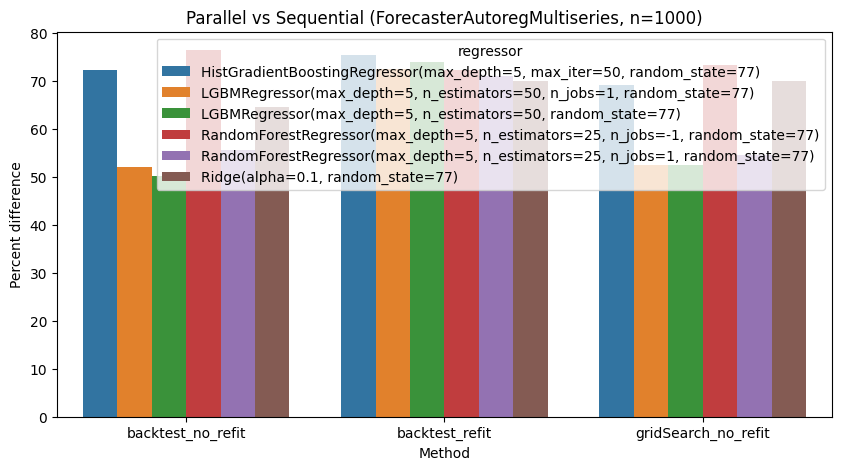

In [15]:
results_pivot = results.pivot_table(index=["regressor", "method"], columns="parallel", values="elapsed_time").reset_index()
results_pivot.columns.name = None
results_pivot["pct_diff"] = (results_pivot[False] - results_pivot[True]) / results_pivot[False] * 100
display(results_pivot)
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(data=results_pivot.dropna(), x="method", y="pct_diff", hue="regressor", ax=ax)
ax.set_title(f"Parallel vs Sequential (ForecasterAutoregMultiseries, n={n})")
ax.set_ylabel("Percent difference")
ax.set_xlabel("Method");
#ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right");

# ForecasterAutoregMultivariate

In [16]:
# Forecaster
# ==============================================================================
print("-----------------------------")
print("ForecasterAutoregMultivariate")
print("-----------------------------")


steps = 25
lags = 50

regressors = [
    Ridge(random_state=77, alpha=0.1),
    LGBMRegressor(random_state=77, n_jobs=1, n_estimators=50, max_depth=5),
    LGBMRegressor(random_state=77, n_jobs=-1, n_estimators=50, max_depth=5),
    HistGradientBoostingRegressor(random_state=77, max_iter=50, max_depth=5),
    RandomForestRegressor(random_state=77, n_jobs=1, n_estimators=25, max_depth=5),
    RandomForestRegressor(random_state=77, n_jobs=-1, n_estimators=25, max_depth=5),
]
param_grids = [
    {'alpha': [0.1, 0.1, 0.1]},
    {'n_estimators': [50, 50], 'max_depth': [5, 5]},
    {'n_estimators': [50, 50], 'max_depth': [5, 5]},
    {'max_iter': [50, 50], 'max_depth': [5, 5]},
    {'n_estimators': [25, 25], 'max_depth': [5, 5]},
    {'n_estimators': [25, 25], 'max_depth': [5, 5]}
]
lags_grid = [50, 50, 50]

elapsed_times = []

for regressor, param_grid in zip(regressors, param_grids):
    print("")
    print(regressor, param_grid)
    print("")
    forecaster = ForecasterAutoregMultiVariate(
        regressor=regressor,
        lags=lags,
        steps=steps,
        level="series_1",
        transformer_exog=StandardScaler()
    )
    
    # Profiling fit
    # ==============================================================================
    print("Profiling fit")
    start = time.time()
    forecaster.fit(series=multi_series, exog=exog)
    end = time.time()
    elapsed_times.append(end - start)
    
    # Profiling create_train_X_y
    # ==============================================================================
    print("Profiling create_train_X_y")
    start = time.time()
    _ = forecaster.create_train_X_y(series=multi_series, exog=exog)
    end = time.time()
    elapsed_times.append(end - start)

    # Profiling backtesting refit and parallel
    # ==============================================================================
    print("Profiling backtesting refit and parallel")
    start = time.time()
    metric, backtest_predictions = backtesting_forecaster_multiseries(
                                    forecaster          = forecaster,
                                    series              = multi_series,
                                    exog                = exog,
                                    initial_train_size  = int(len(y)*0.9),
                                    fixed_train_size    = False,
                                    steps               = steps,
                                    metric              = 'mean_squared_error',
                                    refit               = True,
                                    interval            = None,
                                    n_boot              = 500,
                                    random_state        = 123,
                                    in_sample_residuals = True,
                                    verbose             = False,
                                    show_progress       = False,
                                    n_jobs              = -1
                            )
    end = time.time()
    elapsed_times.append(end - start)
    
    # Profiling backtesting refit and no parallel
    # ==============================================================================
    print("Profiling backtesting refit and no parallel")
    start = time.time()
    metric, backtest_predictions = backtesting_forecaster_multiseries(
                                    forecaster          = forecaster,
                                    series              = multi_series,
                                    exog                = exog,
                                    initial_train_size  = int(len(y)*0.9),
                                    fixed_train_size    = False,
                                    steps               = steps,
                                    metric              = 'mean_squared_error',
                                    refit               = True,
                                    interval            = None,
                                    n_boot              = 500,
                                    random_state        = 123,
                                    in_sample_residuals = True,
                                    verbose             = False,
                                    show_progress       = False,
                                    n_jobs              = 1
                            )
    end = time.time()
    elapsed_times.append(end - start)
    
    # Profiling backtesting no refit and parallel
    # ==============================================================================
    print("Profiling backtesting no refit and parallel")
    start = time.time()
    metric, backtest_predictions = backtesting_forecaster_multiseries(
                                    forecaster          = forecaster,
                                    series              = multi_series,
                                    exog                = exog,
                                    initial_train_size  = int(len(y)*0.9),
                                    fixed_train_size    = False,
                                    steps               = steps,
                                    metric              = 'mean_squared_error',
                                    refit               = False,
                                    interval            = None,
                                    n_boot              = 500,
                                    random_state        = 123,
                                    in_sample_residuals = True,
                                    verbose             = False,
                                    show_progress       = False,
                                    n_jobs              = -1
                            )
    end = time.time()
    elapsed_times.append(end - start)
    
    # Profiling backtesting no refit and no parallel
    # ==============================================================================
    print("Profiling backtesting no refit and no parallel")
    start = time.time()
    metric, backtest_predictions = backtesting_forecaster_multiseries(
                                    forecaster          = forecaster,
                                    series              = multi_series,
                                    exog                = exog,
                                    initial_train_size  = int(len(y)*0.9),
                                    fixed_train_size    = False,
                                    steps               = steps,
                                    metric              = 'mean_squared_error',
                                    refit               = False,
                                    interval            = None,
                                    n_boot              = 500,
                                    random_state        = 123,
                                    in_sample_residuals = True,
                                    verbose             = False,
                                    show_progress       = False,
                                    n_jobs              = 1
                            )
    end = time.time()
    elapsed_times.append(end - start)    
    
    # gridSearch no refit parallel
    # ==============================================================================
    print("Profiling gridSearch no refit parallel")
    start = time.time()
    results_grid = grid_search_forecaster_multiseries(
                    forecaster          = forecaster,
                    series              = multi_series,
                    exog                = exog,
                    initial_train_size  = int(len(y)*0.9),
                    steps               = steps,
                    param_grid         = param_grid,
                    lags_grid          = lags_grid,
                    refit              = False,
                    metric             = 'mean_squared_error',
                    fixed_train_size   = False,
                    return_best        = False,
                    verbose            = False,
                    show_progress      = False,
                    n_jobs             = -1
            )
    end = time.time()
    elapsed_times.append(end - start)
    
    # GridSearch no refit no parallel
    # ==============================================================================
    print("Profiling gridSearch no refit no parallel")
    start = time.time()
    results_grid = grid_search_forecaster_multiseries(
                    forecaster          = forecaster,
                    series              = multi_series,
                    exog                = exog,
                    initial_train_size  = int(len(y)*0.9),
                    steps               = steps,
                    param_grid         = param_grid,
                    lags_grid          = lags_grid,
                    refit              = False,
                    metric             = 'mean_squared_error',
                    fixed_train_size   = False,
                    return_best        = False,
                    verbose            = False,
                    show_progress      = False,
                    n_jobs             = 1
            )
    end = time.time()
    elapsed_times.append(end - start)


methods = [
    "fit",
    "create_train_X_y",
    "backtest_refit_parallel",
    "backtest_refit_noparallel",
    "backtest_no_refit_parallel",
    "backtest_no_refit_noparallel",
    "gridSearch_no_refit_parallel",
    "gridSearch_no_refit_noparallel"
]

results = pd.DataFrame({
     "regressor": np.repeat(np.array([str(regressor) for regressor in regressors]), len(methods)),
     "method": np.tile(methods, len(regressors)),
     "elapsed_time": elapsed_times
})

results['parallel'] = results.method.str.contains("_parallel")
results['method'] = results.method.str.replace("_parallel", "")
results['method'] = results.method.str.replace("_noparallel", "")
results = results.sort_values(by=["regressor", "method", "parallel"])
results.to_csv(f"javi_profiling_results_ForecasterAutoregMultivariate_{n}.csv", index=False)
results

-----------------------------
ForecasterAutoregMultivariate
-----------------------------

Ridge(alpha=0.1, random_state=77) {'alpha': [0.1, 0.1, 0.1]}

Profiling fit
Profiling create_train_X_y
Profiling backtesting refit and parallel
Profiling backtesting refit and no parallel
Profiling backtesting no refit and parallel
Profiling backtesting no refit and no parallel
Profiling gridSearch no refit parallel
9 models compared for 1 level(s). Number of iterations: 9.
Profiling gridSearch no refit no parallel
9 models compared for 1 level(s). Number of iterations: 9.

LGBMRegressor(max_depth=5, n_estimators=50, n_jobs=1, random_state=77) {'n_estimators': [50, 50], 'max_depth': [5, 5]}

Profiling fit
Profiling create_train_X_y
Profiling backtesting refit and parallel
Profiling backtesting refit and no parallel
Profiling backtesting no refit and parallel
Profiling backtesting no refit and no parallel
Profiling gridSearch no refit parallel
12 models compared for 1 level(s). Number of iteration

,regressor,method,elapsed_time,parallel
29,"HistGradientBoostingRegressor(max_depth=5, max...",backtest_no_refit,27.170058,False
28,"HistGradientBoostingRegressor(max_depth=5, max...",backtest_no_refit,29.012573,True
27,"HistGradientBoostingRegressor(max_depth=5, max...",backtest_refit,112.676618,False
26,"HistGradientBoostingRegressor(max_depth=5, max...",backtest_refit,39.043919,True
25,"HistGradientBoostingRegressor(max_depth=5, max...",create_train_X_y,0.015002,False
24,"HistGradientBoostingRegressor(max_depth=5, max...",fit,29.197726,False
31,"HistGradientBoostingRegressor(max_depth=5, max...",gridSearch_no_refit,323.519109,False
30,"HistGradientBoostingRegressor(max_depth=5, max...",gridSearch_no_refit,343.306501,True
13,"LGBMRegressor(max_depth=5, n_estimators=50, n_...",backtest_no_refit,11.740311,False
12,"LGBMRegressor(max_depth=5, n_estimators=50, n_...",backtest_no_refit,11.955646,True


,regressor,method,False,True,pct_diff
0,"HistGradientBoostingRegressor(max_depth=5, max...",backtest_no_refit,27.170058,29.012573,-6.781418
1,"HistGradientBoostingRegressor(max_depth=5, max...",backtest_refit,112.676618,39.043919,65.348694
2,"HistGradientBoostingRegressor(max_depth=5, max...",create_train_X_y,0.015002,NaN,NaN
3,"HistGradientBoostingRegressor(max_depth=5, max...",fit,29.197726,NaN,NaN
4,"HistGradientBoostingRegressor(max_depth=5, max...",gridSearch_no_refit,323.519109,343.306501,-6.116298
5,"LGBMRegressor(max_depth=5, n_estimators=50, n_...",backtest_no_refit,11.740311,11.955646,-1.834152
6,"LGBMRegressor(max_depth=5, n_estimators=50, n_...",backtest_refit,47.816131,16.225958,66.065933
7,"LGBMRegressor(max_depth=5, n_estimators=50, n_...",create_train_X_y,0.016137,NaN,NaN
8,"LGBMRegressor(max_depth=5, n_estimators=50, n_...",fit,12.342955,NaN,NaN
9,"LGBMRegressor(max_depth=5, n_estimators=50, n_...",gridSearch_no_refit,139.970710,141.677407,-1.219324


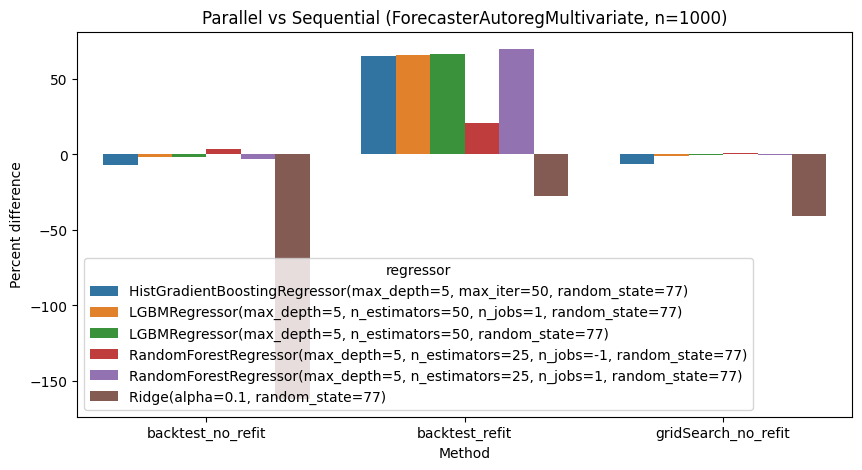

In [17]:
results_pivot = results.pivot_table(index=["regressor", "method"], columns="parallel", values="elapsed_time").reset_index()
results_pivot.columns.name = None
results_pivot["pct_diff"] = (results_pivot[False] - results_pivot[True]) / results_pivot[False] * 100
display(results_pivot)
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(data=results_pivot.dropna(), x="method", y="pct_diff", hue="regressor", ax=ax)
ax.set_title(f"Parallel vs Sequential (ForecasterAutoregMultivariate, n={n})")
ax.set_ylabel("Percent difference")
ax.set_xlabel("Method");
#ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right");

In [18]:
# Last execution of this notebook
# ==============================================================================
print(f"Last execution: {pd.Timestamp.now()}")

Last execution: 2023-06-22 11:11:39.384998
